In [1]:
import pandas as pd
from src.visualization.visualize import display_source, make_wordcloud
from numpy.random import choice

data = pd.read_csv('../data/raw/dataset.csv')

## Data Preparation

In this section we take an in depth look at the data preparation process. All data processing is handled by the `data_cleaning` module.

In [2]:
from src.data import data_cleaning
display_source(data_cleaning)

```python
"""
This module provides the full data cleaning pipeline.
"""

__author__ = "Seth Chart"
__version__ = "0.1.0"
__license__ = "MIT"

from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from typing import List, Tuple

lemmatizer = WordNetLemmatizer()


def doc_tokenizer(doc: str) -> List[List[str]]:
    """doc_tokenizer. Reads in a raw text document and returns a list of
    sentences each represented as a list of words. Text is converted to
    lower_case and newline characters are removed.

    Parameters
    ----------
    doc : str
        doc is a document encoded as a string.
    Returns
    -------
    List[List[str]]

    """
    doc = doc.replace('\\n', '').lower()
    sentences = sent_tokenize(doc)
    doc_tokens = [word_tokenize(sentence) for sentence in sentences]
    return doc_tokens


def get_wordnet_pos(treebank_tag: Tuple[str, str]) -> str:
    """get_wordnet_pos. Converts a treebank POS tag to a wordnet POS tag.

    Parameters
    ----------
    treebank_tag : Tuple[str, str]
        treebank_tag first position is the token, second position is the
        treebank POS tag.

    Returns
    -------
    str
    """
    if treebank_tag.startswith('J'):
        tag = wordnet.ADJ
    elif treebank_tag.startswith('V'):
        tag = wordnet.VERB
    elif treebank_tag.startswith('N'):
        tag = wordnet.NOUN
    elif treebank_tag.startswith('R'):
        tag = wordnet.ADV
    else:
        tag = ''
    return tag


def sentence_pos_tagger(sentence: List[str]) -> List[Tuple[str, str]]:
    """sentence_pos_tagger. Takes a sentence as a list of tokens and returns a
    list of wordnet POS tagged tokens.

    Parameters
    ----------
    sentence : List[str]
        sentence is a list of word tokens from a sentence.

    Returns
    -------
    List[Tuple[str, str]]

    """
    treebank_tags = pos_tag(sentence)
    wordnet_tags = [
        (treebank_tag[0], get_wordnet_pos(treebank_tag[1]))
        for treebank_tag in treebank_tags
    ]
    return wordnet_tags


def doc_pos_tagger(doc_tokens: List[List[str]]) -> List[List[Tuple[str, str]]]:
    """doc_pos_tagger. Takes a tokenized document and returns POS tagged
    tokens.

    Parameters
    ----------
    doc_tokens : List[List[str]]
        doc_tokens the output of doc_tokenizer.

    Returns
    -------
    List[List[Tuple[str, str]]]

    """
    pos_tags = [
        sentence_pos_tagger(sentence) for sentence in doc_tokens
    ]
    return pos_tags


def tag_lemmatizer(pos_tag: Tuple[str, str]) -> str:
    """tag_lemmatizer. Takes a POS tagged word and returns its Lemma.

    Parameters
    ----------
    pos_tag : Tuple[str, str]
        pos_tag first position is a word token, second position is a wordnet POS tag.

    Returns
    -------
    str
    """
    if pos_tag[1] != '':
        lemmatized_word = lemmatizer.lemmatize(pos_tag[0], pos_tag[1])
    else:
        lemmatized_word = pos_tag[0]
    return lemmatized_word


def sentence_lemmatizer(sentence_tags: List[Tuple[str, str]]) -> List[str]:
    """sentence_lemmatizer. Takes a POS tagged sentence and lemmatizes.

    Parameters
    ----------
    sentence_tags : List[Tuple[str, str]]
        sentence_tags list of POS tagged tokens that form a sentence.

    Returns
    -------
    List[str]

    """
    lemmatized_sentence = [
        tag_lemmatizer(pos_tag) for pos_tag in sentence_tags
    ]
    return lemmatized_sentence


def doc_lemmatizer(doc_tags: List[List[Tuple[str, str]]]) -> List[str]:
    """doc_lemmatizer. Lemmatize tagged words from a job doc and flatten
    sentence nesting.

    Parameters
    ----------
    doc_tags : List[List[Tuple[str, str]]]
        doc_tags output from doc_pos_tagger.

    Returns
    -------
    List[str]

    """
    lemmatized_doc = []
    for sentence_tags in doc_tags:
        lemmatized_sentence = sentence_lemmatizer(sentence_tags)
        lemmatized_doc.extend(lemmatized_sentence)
    return lemmatized_doc


def doc_clean(lemmatized_doc: List[str]) -> List[str]:
    """doc_clean. Takes a lemmatized document, drops special characters and
    stopwords.

    Parameters
    ----------
    lemmatized_doc : List[str]
        lemmatized_doc output from doc_lemmatizer.

    Returns
    -------
    List[str]

    """
    my_stopwords = stopwords.words('english')
    processed_doc = [
        word for word in lemmatized_doc
        if word.isalpha() and word not in my_stopwords and len(word)>1
    ]
    return processed_doc


def doc_processor(doc: str) -> List[str]:
    """doc_processor. Executes full data processing pipeline on a document with
    the exception of bigram and trigram grouping.

    Parameters
    ----------
    doc : str
        doc is a  string containing the full text of your document.

    Returns
    -------
    List[str]

    """
    doc_tokens = doc_tokenizer(doc)
    doc_tags = doc_pos_tagger(doc_tokens)
    lemmatized_doc = doc_lemmatizer(doc_tags)
    processed_doc = doc_clean(lemmatized_doc)
    return processed_doc


def data_processor(docs: List[str]) -> List[List[str]]:
    """data_processor. Takes a list of raw documents and executes full data
    processing pipeline for every document in the list.

    Parameters
    ----------
    docs : List[str]
        docs is a list of strings containing the full text of your documents.

    Returns
    -------
    List[List[str]]

    """
    processed_data = [
        doc_processor(doc) for doc in docs
    ]
    return processed_data


def data_combine_phrases(
    processed_data: List[List[str]], prefix: str
) -> List[List[str]]:
    """data_combine_phrases. Takes a corpus of cleaned documents and combines
    common phrases into bigrams, trigrams, and quadgrams.

    Parameters
    ----------
    processed_data : List[List[str]]
        processed_data output from data processor.
    prefix : str
        prefix to identify saved model.

    Returns
    -------
    List[List[str]]
    """
    phrase_model_1 = Phrases(processed_data)
    phrase_model_1.save(f'../model/{prefix}-phrase_model_1.pkl')
    phrase_model_2 = Phrases(phrase_model_1[processed_data], min_count=1)
    phrase_model_2.save(f'../model/{prefix}-phrase_model_2.pkl')
    data_phrases = list(phrase_model_2[phrase_model_1[processed_data]])
    return data_phrases


def doc_combine_phrases(processed_doc: List[str], prefix: str) -> List[str]:
    """doc_combine_phrases. Takes a processed document and combines common
    phrases into bigrams, trigrams, and quadgrams. data_combine_phrases must
    run before doc_combine_phrases.

    Parameters
    ----------
    processed_doc : List[str]
        processed_doc output from doc_processor,
    prefix : str
        prefix to identify saved model.

    Returns
    -------
    List[str]
    """
    try:
        phrase_model_1 = Phrases.load(f'../model/{prefix}-phrase_model_1.pkl')
        phrase_model_2 = Phrases.load(f'../model/{prefix}-phrase_model_2.pkl')
    except:
        print('Call `data_combine_phrases` on processed data to build a phrase model')
        pass
    doc_phrases = list(phrase_model_2[phrase_model_1[processed_doc]])
    return doc_phrases

```

### Data Cleaning

To quickly demonstrate the steps in our data cleaning pipeline, we will select a single example record and apply each step in sequence.

#### Selecting an Example Job Post

Below we select a job posting at random from the data.

In [3]:
example_index = choice(len(data))
job_post = data.iloc[example_index]
title = job_post['title']
description = job_post['description']
print(f'{title}\n\n{description}')

Data Analyst, Media Partnerships Strategy & Planning

\n  \n    The Media Partnerships team works with leading content creators, publishers, and businesses across Entertainment, News, and Sports, ensuring that Facebook is a primary channel to engage with their audience and drive their business. We seek an experienced Data Analyst to join the Media Partnerships Strategic Planning & Operations (SP&O) team in support of this work. The Data Analyst in this position will help identify opportunities to improve our partner management strategy and contribute to discussions around resource allocation and process optimization. The ideal candidate is passionate about leveraging data to drive business strategy, has hands-on experience with state of the industry analytics software and techniques, and is effective at communicating insights and recommendations to leadership and executives.  Data Analyst, Media Partnerships Strategy & Planning Responsibilities  Co-own/support end-to-end development of

##### Raw description word cloud

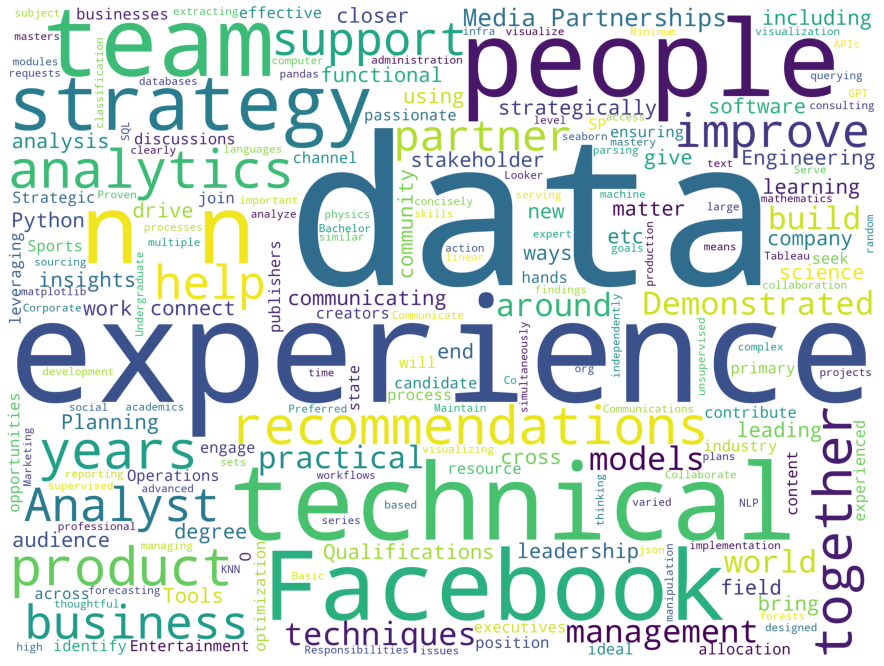

In [4]:
fig = make_wordcloud(description)

#### Tokenizing Text

The `doc_tokenizer` method first splits a document into a list of sentences, then splits each sentence into a list of words. This method depends on the following methods:
 * `sent_tokenize` and `word_tokenize` from `nltk.tokenize`.

##### `doc_tokenizer` method

In [5]:
display_source(data_cleaning.doc_tokenizer)

```python
def doc_tokenizer(doc: str) -> List[List[str]]:
    """doc_tokenizer. Reads in a raw text document and returns a list of
    sentences each represented as a list of words. Text is converted to
    lower_case and newline characters are removed.

    Parameters
    ----------
    doc : str
        doc is a document encoded as a string.
    Returns
    -------
    List[List[str]]

    """
    doc = doc.replace('\\n', '').lower()
    sentences = sent_tokenize(doc)
    doc_tokens = [word_tokenize(sentence) for sentence in sentences]
    return doc_tokens

```

##### Example output

In [6]:
title_tokens = data_cleaning.doc_tokenizer(title)
description_tokens = data_cleaning.doc_tokenizer(description)
print(f'{title_tokens}\n\n{description_tokens}')

[['data', 'analyst', ',', 'media', 'partnerships', 'strategy', '&', 'planning']]

[['the', 'media', 'partnerships', 'team', 'works', 'with', 'leading', 'content', 'creators', ',', 'publishers', ',', 'and', 'businesses', 'across', 'entertainment', ',', 'news', ',', 'and', 'sports', ',', 'ensuring', 'that', 'facebook', 'is', 'a', 'primary', 'channel', 'to', 'engage', 'with', 'their', 'audience', 'and', 'drive', 'their', 'business', '.'], ['we', 'seek', 'an', 'experienced', 'data', 'analyst', 'to', 'join', 'the', 'media', 'partnerships', 'strategic', 'planning', '&', 'operations', '(', 'sp', '&', 'o', ')', 'team', 'in', 'support', 'of', 'this', 'work', '.'], ['the', 'data', 'analyst', 'in', 'this', 'position', 'will', 'help', 'identify', 'opportunities', 'to', 'improve', 'our', 'partner', 'management', 'strategy', 'and', 'contribute', 'to', 'discussions', 'around', 'resource', 'allocation', 'and', 'process', 'optimization', '.'], ['the', 'ideal', 'candidate', 'is', 'passionate', 'about', 

#### Parts of Speech Tagging

The `doc_pos_tagger` method parses the tokenized text from the step above and applies a wordnet part of speech tag. This method depends on the following methods:
 * `sentence_pos_tagger` and `get_wordnet_pos` from `data_cleaning`
 * `pos_tag` from `nltk`
 * `wordnet` from `nltk.corpus`

##### `doc_pos_tagger` method

In [7]:
display_source(data_cleaning.doc_pos_tagger)

```python
def doc_pos_tagger(doc_tokens: List[List[str]]) -> List[List[Tuple[str, str]]]:
    """doc_pos_tagger. Takes a tokenized document and returns POS tagged
    tokens.

    Parameters
    ----------
    doc_tokens : List[List[str]]
        doc_tokens the output of doc_tokenizer.

    Returns
    -------
    List[List[Tuple[str, str]]]

    """
    pos_tags = [
        sentence_pos_tagger(sentence) for sentence in doc_tokens
    ]
    return pos_tags

```

##### Example output

In [8]:
title_pos_tags = data_cleaning.doc_pos_tagger(title_tokens)
description_pos_tags = data_cleaning.doc_pos_tagger(description_tokens)
print(f'{title_pos_tags}\n\n{description_pos_tags}')

[[('data', 'n'), ('analyst', 'n'), (',', ''), ('media', 'n'), ('partnerships', 'n'), ('strategy', 'n'), ('&', ''), ('planning', 'n')]]

[[('the', ''), ('media', 'n'), ('partnerships', 'n'), ('team', 'n'), ('works', 'v'), ('with', ''), ('leading', 'v'), ('content', 'a'), ('creators', 'n'), (',', ''), ('publishers', 'n'), (',', ''), ('and', ''), ('businesses', 'n'), ('across', ''), ('entertainment', 'n'), (',', ''), ('news', 'n'), (',', ''), ('and', ''), ('sports', 'n'), (',', ''), ('ensuring', 'v'), ('that', ''), ('facebook', 'n'), ('is', 'v'), ('a', ''), ('primary', 'a'), ('channel', 'n'), ('to', ''), ('engage', 'v'), ('with', ''), ('their', ''), ('audience', 'n'), ('and', ''), ('drive', 'v'), ('their', ''), ('business', 'n'), ('.', '')], [('we', ''), ('seek', 'v'), ('an', ''), ('experienced', 'a'), ('data', 'n'), ('analyst', 'n'), ('to', ''), ('join', 'v'), ('the', ''), ('media', 'n'), ('partnerships', 'n'), ('strategic', 'a'), ('planning', 'n'), ('&', ''), ('operations', 'n'), ('(', 

##### `sentence_pos_tagger` method

In [9]:
display_source(data_cleaning.sentence_pos_tagger)

```python
def sentence_pos_tagger(sentence: List[str]) -> List[Tuple[str, str]]:
    """sentence_pos_tagger. Takes a sentence as a list of tokens and returns a
    list of wordnet POS tagged tokens.

    Parameters
    ----------
    sentence : List[str]
        sentence is a list of word tokens from a sentence.

    Returns
    -------
    List[Tuple[str, str]]

    """
    treebank_tags = pos_tag(sentence)
    wordnet_tags = [
        (treebank_tag[0], get_wordnet_pos(treebank_tag[1]))
        for treebank_tag in treebank_tags
    ]
    return wordnet_tags

```

##### `get_wordnet_pos` method

In [10]:
display_source(data_cleaning.get_wordnet_pos)

```python
def get_wordnet_pos(treebank_tag: Tuple[str, str]) -> str:
    """get_wordnet_pos. Converts a treebank POS tag to a wordnet POS tag.

    Parameters
    ----------
    treebank_tag : Tuple[str, str]
        treebank_tag first position is the token, second position is the
        treebank POS tag.

    Returns
    -------
    str
    """
    if treebank_tag.startswith('J'):
        tag = wordnet.ADJ
    elif treebank_tag.startswith('V'):
        tag = wordnet.VERB
    elif treebank_tag.startswith('N'):
        tag = wordnet.NOUN
    elif treebank_tag.startswith('R'):
        tag = wordnet.ADV
    else:
        tag = ''
    return tag

```

#### Lemmatization

The `doc_lemmatizer` method parses the POS tagged text and, where possible, replaces words with their [lemmas](https://en.wikipedia.org/wiki/Lemmatisation). This method depends on the following methods and classes:
 * `sentence_lemmatizer` and `tag_lemmatizer` from `data_cleaning`
 * `WordNetLemmatizer` from `nltk.stem.wordnet`

##### `doc_lemmatizer` method

In [11]:
display_source(data_cleaning.doc_lemmatizer)

```python
def doc_lemmatizer(doc_tags: List[List[Tuple[str, str]]]) -> List[str]:
    """doc_lemmatizer. Lemmatize tagged words from a job doc and flatten
    sentence nesting.

    Parameters
    ----------
    doc_tags : List[List[Tuple[str, str]]]
        doc_tags output from doc_pos_tagger.

    Returns
    -------
    List[str]

    """
    lemmatized_doc = []
    for sentence_tags in doc_tags:
        lemmatized_sentence = sentence_lemmatizer(sentence_tags)
        lemmatized_doc.extend(lemmatized_sentence)
    return lemmatized_doc

```

##### Example output

In [12]:
title_lemmas = data_cleaning.doc_lemmatizer(title_pos_tags)
description_lemmas = data_cleaning.doc_lemmatizer(description_pos_tags)
print(f'{title_lemmas}\n\n{description_lemmas}')

['data', 'analyst', ',', 'medium', 'partnership', 'strategy', '&', 'planning']

['the', 'medium', 'partnership', 'team', 'work', 'with', 'lead', 'content', 'creator', ',', 'publisher', ',', 'and', 'business', 'across', 'entertainment', ',', 'news', ',', 'and', 'sport', ',', 'ensure', 'that', 'facebook', 'be', 'a', 'primary', 'channel', 'to', 'engage', 'with', 'their', 'audience', 'and', 'drive', 'their', 'business', '.', 'we', 'seek', 'an', 'experienced', 'data', 'analyst', 'to', 'join', 'the', 'medium', 'partnership', 'strategic', 'planning', '&', 'operation', '(', 'sp', '&', 'o', ')', 'team', 'in', 'support', 'of', 'this', 'work', '.', 'the', 'data', 'analyst', 'in', 'this', 'position', 'will', 'help', 'identify', 'opportunity', 'to', 'improve', 'our', 'partner', 'management', 'strategy', 'and', 'contribute', 'to', 'discussion', 'around', 'resource', 'allocation', 'and', 'process', 'optimization', '.', 'the', 'ideal', 'candidate', 'be', 'passionate', 'about', 'leverage', 'data', 'to'

##### `sentence_lemmatizer` method

In [13]:
display_source(data_cleaning.sentence_lemmatizer)

```python
def sentence_lemmatizer(sentence_tags: List[Tuple[str, str]]) -> List[str]:
    """sentence_lemmatizer. Takes a POS tagged sentence and lemmatizes.

    Parameters
    ----------
    sentence_tags : List[Tuple[str, str]]
        sentence_tags list of POS tagged tokens that form a sentence.

    Returns
    -------
    List[str]

    """
    lemmatized_sentence = [
        tag_lemmatizer(pos_tag) for pos_tag in sentence_tags
    ]
    return lemmatized_sentence

```

##### `tag_lemmatizer` method

In [14]:
display_source(data_cleaning.tag_lemmatizer)

```python
def tag_lemmatizer(pos_tag: Tuple[str, str]) -> str:
    """tag_lemmatizer. Takes a POS tagged word and returns its Lemma.

    Parameters
    ----------
    pos_tag : Tuple[str, str]
        pos_tag first position is a word token, second position is a wordnet POS tag.

    Returns
    -------
    str
    """
    if pos_tag[1] != '':
        lemmatized_word = lemmatizer.lemmatize(pos_tag[0], pos_tag[1])
    else:
        lemmatized_word = pos_tag[0]
    return lemmatized_word

```

#### Clean Up

The `doc_clean` method removes special characters and stopwords. It depends on the following methods.
 * `stopwords` from `nltk.corpus`

##### `doc_clean` method

In [15]:
display_source(data_cleaning.doc_clean)

```python
def doc_clean(lemmatized_doc: List[str]) -> List[str]:
    """doc_clean. Takes a lemmatized document, drops special characters and
    stopwords.

    Parameters
    ----------
    lemmatized_doc : List[str]
        lemmatized_doc output from doc_lemmatizer.

    Returns
    -------
    List[str]

    """
    my_stopwords = stopwords.words('english')
    processed_doc = [
        word for word in lemmatized_doc
        if word.isalpha() and word not in my_stopwords and len(word)>1
    ]
    return processed_doc

```

##### Example output

In [16]:
title_clean = data_cleaning.doc_clean(title_lemmas)
description_clean = data_cleaning.doc_clean(description_lemmas)
print(f'{title_clean}\n\n{description_clean}')

['data', 'analyst', 'medium', 'partnership', 'strategy', 'planning']

['medium', 'partnership', 'team', 'work', 'lead', 'content', 'creator', 'publisher', 'business', 'across', 'entertainment', 'news', 'sport', 'ensure', 'facebook', 'primary', 'channel', 'engage', 'audience', 'drive', 'business', 'seek', 'experienced', 'data', 'analyst', 'join', 'medium', 'partnership', 'strategic', 'planning', 'operation', 'sp', 'team', 'support', 'work', 'data', 'analyst', 'position', 'help', 'identify', 'opportunity', 'improve', 'partner', 'management', 'strategy', 'contribute', 'discussion', 'around', 'resource', 'allocation', 'process', 'optimization', 'ideal', 'candidate', 'passionate', 'leverage', 'data', 'drive', 'business', 'strategy', 'experience', 'state', 'industry', 'analytics', 'software', 'technique', 'effective', 'communicate', 'insight', 'recommendation', 'leadership', 'executive', 'data', 'analyst', 'medium', 'partnership', 'strategy', 'planning', 'responsibility', 'development', 'dat

##### Clean word cloud

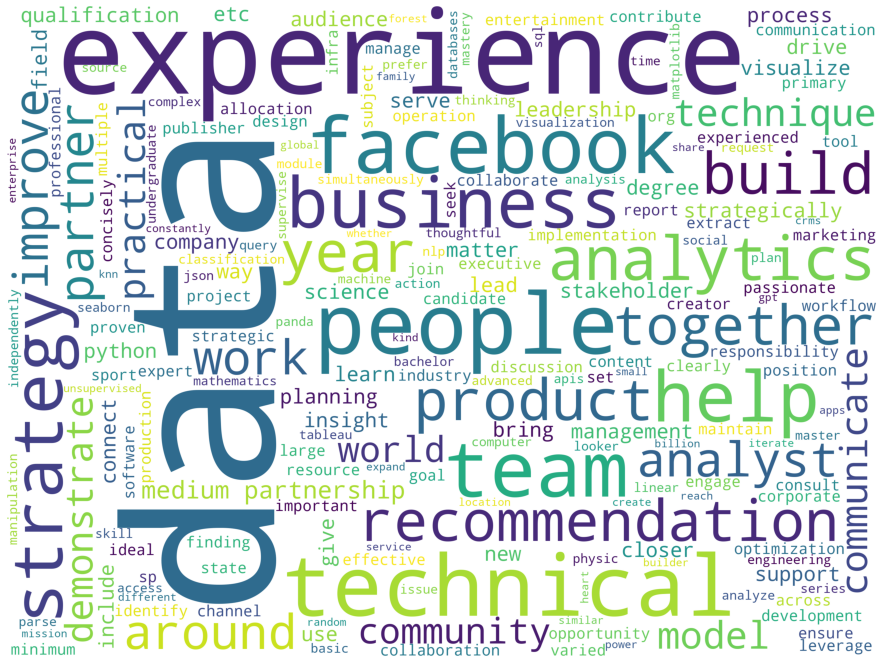

In [17]:
description_clean_text = ' '.join(description_clean)
fig = make_wordcloud(description_clean_text)